# VASCULOMICS

In the following noteebok, different CNN architectures are defined and trained. Posteriorly, GradCAM is applied as an explainabilty technique, and finally the optimal selected model is validated.

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load data

To start, the data is loaded from a folder saved in google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Images are stored in two npy file, which are loades separately.

In [3]:
# Change here the root path where the folders with the images and the trained models are stored
path='/content/drive/MyDrive/Pràctiques SJD Júlia i Clara/IA/'

'/content/drive/MyDrive/Pràctiques SJD Júlia i Clara/IA/npy_images/npy_avm.npy'

In [ ]:
# directly load npy images from folder
avm_images_path=path+'npy_images/npy_avm.npy'
images_avm = np.load(avm_images_path)
print(f'Number of avm images: {len(images_avm)}')

Number of avm images: 387


In [ ]:
# directly load npy images from folder
normal_images_path=path+'npy_images/npy_normal.npy'
images_normal = np.load(normal_images_path) 
print(f'Number of normal images: {len(images_normal)}')

Number of normal images: 545


Four images are saved for later to use them for a posterior validation of the selected model

In [ ]:
images_normal=images_normal[0:-2]
validation_normal=images_normal[-2:]
print(f'Shape of validation data healthy images: {validation_normal.shape}')
print(f'Shape of normal images: {images_normal.shape}')

Shape of validation data healthy images: (2, 320, 320)
Shape of normal images: (543, 320, 320)


In [ ]:
images_avm=images_avm[0:-2]
validation_avm=images_avm[-2:]

print(f'Shape of validation data avm images: {validation_avm.shape}')
print(f'Shape of avm images: {images_avm.shape}')

Shape of validation data avm images: (2, 320, 320)
Shape of avm images: (385, 320, 320)


The rest of the data will be used as a train/test data:

**Train/ test data**

There are two classes:
- 0: healyhy
- 1: AVM, pathologic

In [ ]:
# create an array of 1 as label for AVM images
y_avm = [1] * len(images_avm)
# create an array of 0 as label for AVM images
y_normal = [0] * len(images_normal)

In [ ]:
x=np.concatenate((images_normal, images_avm), axis=0)
y=np.concatenate((y_normal, y_avm), axis=0)

**Validation data:**

In [ ]:
#load avm
val_avm = [1] * len(validation_avm)
#load normal
val_normal = [0] * len(validation_normal)

In [ ]:
val_x=np.concatenate((validation_normal, validation_avm), axis=0)
val_y=np.concatenate((val_normal, val_avm), axis=0)

# Deep learning

The images are splitted into train and test:

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0,train_size=0.7)



Then, the labels are converted to categorical

In [ ]:
num_classes=2
# convert class vectors to binary class matrices
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

Images nornmalization and expand dimensions:

In [ ]:
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Expand dimensions
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (649, 320, 320, 1)
649 train samples
279 test samples


## CNN

The first CNN is defined

In [ ]:
# Model / data parameters
input_shape=(320,320,1)

CNN = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(name="features"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

CNN.summary()

CNN.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 318, 318, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 159, 159, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 157, 157, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 78, 78, 64)       0         
 2D)                                                             
                                                                 
 features (Flatten)          (None, 389376)            0         
                                                                 
 dropout (Dropout)           (None, 389376)            0

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Uncomment to train the model
batch_size =32 
epochs = 30
#filepath=path+'models/CNN.h5'
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#history=CNN.fit(x_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.1,callbacks=checkpoint)


Epoch 1/30
19/19 [==============================] - ETA: 0s - loss: 0.4058 - accuracy: 0.8322
Epoch 1: val_loss improved from inf to 0.24576, saving model to /content/drive/MyDrive/Pràctiques SJD Júlia i Clara/IA/CNN.h5
19/19 [==============================] - 15s 124ms/step - loss: 0.4058 - accuracy: 0.8322 - val_loss: 0.2458 - val_accuracy: 0.9231
Epoch 2/30
18/19 [===========================>..] - ETA: 0s - loss: 0.1126 - accuracy: 0.9635
Epoch 2: val_loss improved from 0.24576 to 0.12053, saving model to /content/drive/MyDrive/Pràctiques SJD Júlia i Clara/IA/CNN.h5
19/19 [==============================] - 2s 96ms/step - loss: 0.1113 - accuracy: 0.9640 - val_loss: 0.1205 - val_accuracy: 0.9538
Epoch 3/30
18/19 [===========================>..] - ETA: 0s - loss: 0.0500 - accuracy: 0.9878
Epoch 3: val_loss improved from 0.12053 to 0.09305, saving model to /content/drive/MyDrive/Pràctiques SJD Júlia i Clara/IA/CNN.h5
19/19 [==============================] - 2s 92ms/step - loss: 0.

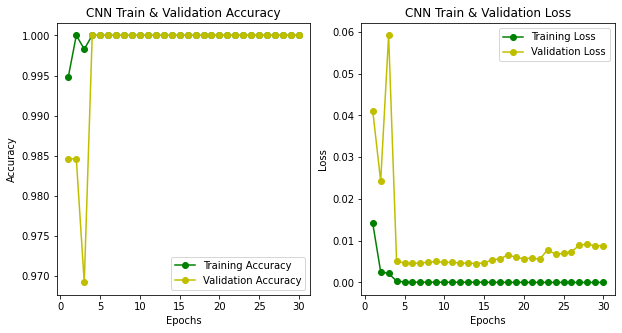

In [ ]:
#Plot the training and valditacion accuracy across epochs
fig , ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs, train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('CNN Train & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs, val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('CNN Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Restore the weights
filepath_CNN=path+'models/CNN.h5'
CNN.load_weights(filepath_CNN)

# Evaluate the model
score = CNN.evaluate(x_test, y_test_cat, verbose=2)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
label_names = ['Healthy', 'AVM']
# Make predictions
y_test_pred_DL_full_CNN = np.argmax(CNN.predict(x_test),axis=1) # convert back from one-hot categorical encoding to integers

# Classification metrics
print(classification_report(y_test, y_test_pred_DL_full_CNN, target_names=label_names))
cm=confusion_matrix(y_test, y_test_pred_DL_full_CNN)
print(cm)

9/9 - 5s - loss: 0.0382 - accuracy: 0.9928 - 5s/epoch - 522ms/step
Test loss: 0.0381600521504879
Test accuracy: 0.9928315281867981
9/9 [==============================] - 0s 38ms/step
              precision    recall  f1-score   support

     Healthy       0.99      0.99      0.99       166
         AVM       0.99      0.99      0.99       113

    accuracy                           0.99       279
   macro avg       0.99      0.99      0.99       279
weighted avg       0.99      0.99      0.99       279

[[165   1]
 [  1 112]]


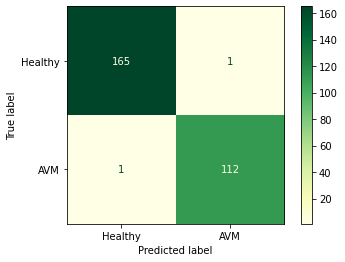

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label_names)
disp.plot(cmap='YlGn')


We identify the images which are misclassified:

In [ ]:
#TRUE POSITIVES
isel_tp_CNN = np.where((y_test==1)&(y_test_pred_DL_full_CNN==1))
isel_tp_CNN = np.squeeze(isel_tp_CNN)
#TRUE NEGATIVES
isel_tn_CNN = np.where((y_test==0)&(y_test_pred_DL_full_CNN==0))
isel_tn_CNN = np.squeeze(isel_tn_CNN)
#FALSE POSITIVES
isel_fp_CNN = np.where((y_test==0)&(y_test_pred_DL_full_CNN==1))
isel_fp_CNN = np.squeeze(isel_fp_CNN)
#FALSE NEGATIVES
isel_fn_CNN = np.where((y_test==1)&(y_test_pred_DL_full_CNN==0))
isel_fn_CNN = np.squeeze(isel_fn_CNN)

**FALSE POSITIVES**

(-0.5, 319.5, 319.5, -0.5)

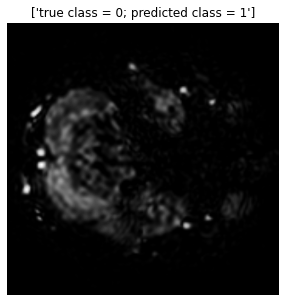

In [ ]:
fig = plt.figure(figsize=(5, 5))
k=isel_fp_CNN
plt.imshow(np.squeeze(x_test[k]),cmap=plt.cm.gray)
plt.title(['true class = {}; predicted class = {}'.format(y_test[k],y_test_pred_DL_full_CNN[k])])
plt.axis('off')

**FALSE NEGATIVE**

(-0.5, 319.5, 319.5, -0.5)

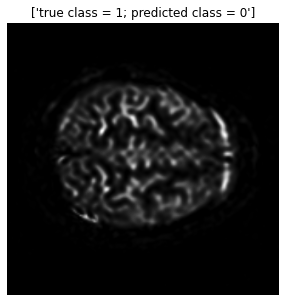

In [ ]:
fig = plt.figure(figsize=(5, 5))
k=isel_fn_CNN
plt.imshow(np.squeeze(x_test[k]),cmap=plt.cm.gray)
plt.title(['true class = {}; predicted class = {}'.format(y_test[k],y_test_pred_DL_full_CNN[k])])
plt.axis('off')

## CNN_amp

Definition of the second CNN model, which only differs from the first by the addition of another convolutional layer

In [ ]:
input_shape=(320,320,1)

CNN_amp = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(96, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(name="features"),
        layers.Dropout(0.5),
        layers.Dense(2, activation="softmax"),
    ]
)

CNN_amp.summary()

CNN_amp.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 318, 318, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 159, 159, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 157, 157, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 78, 78, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 76, 76, 96)        55392     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 38, 38, 96)      

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Uncomment to train the model

batch_size =32 
epochs = 40
#filepath=path+'models/CNN_amp.h5'
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#history_CNN_amp=CNN_amp.fit(x_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.1,callbacks=checkpoint)


Epoch 1/55
18/19 [===========================>..] - ETA: 0s - loss: 8.4956e-06 - accuracy: 1.0000
Epoch 1: val_loss improved from inf to 0.00339, saving model to /content/drive/MyDrive/Pràctiques SJD Júlia i Clara/IA/CNN_amp.h5
19/19 [==============================] - 3s 136ms/step - loss: 8.6421e-06 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 2/55
18/19 [===========================>..] - ETA: 0s - loss: 9.4826e-06 - accuracy: 1.0000
Epoch 2: val_loss did not improve from 0.00339
19/19 [==============================] - 2s 95ms/step - loss: 9.3578e-06 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 3/55
18/19 [===========================>..] - ETA: 0s - loss: 7.4795e-06 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 0.00339
19/19 [==============================] - 2s 94ms/step - loss: 7.3817e-06 - accuracy: 1.0000 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 4/55
18/19 [===========================>..] - ETA: 0s - loss: 9.2251e-0

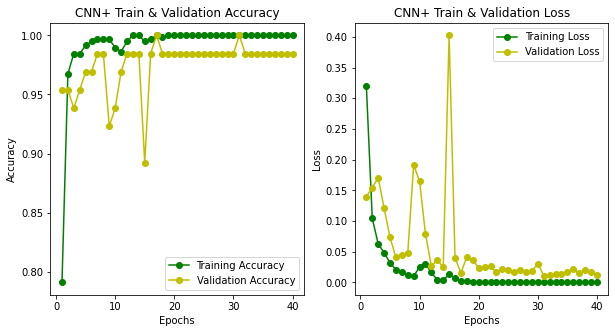

In [ ]:
#Plot the training artifacts
fig , ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

train_acc = history_CNN_amp.history['accuracy']
train_loss = history_CNN_amp.history['loss']
val_acc = history_CNN_amp.history['val_accuracy']
val_loss = history_CNN_amp.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs, train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('CNN+ Train & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs, val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('CNN+ Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Restore the weights
filepath_CNN=path+'models/CNN_amp.h5'
CNN_amp.load_weights(filepath_CNN)

# Evaluate the model
score = CNN_amp.evaluate(x_test, y_test_cat, verbose=2)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
label_names = ['Healthy', 'AVM']
# Make predictions
y_test_pred_DL_full_CNN_amp = np.argmax(CNN_amp.predict(x_test),axis=1) # convert back from one-hot categorical encoding to integers

# Classification metrics
print(classification_report(y_test, y_test_pred_DL_full_CNN_amp, target_names=label_names))
cm=confusion_matrix(y_test, y_test_pred_DL_full_CNN_amp)
print(cm)

9/9 - 1s - loss: 0.0586 - accuracy: 0.9892 - 1s/epoch - 124ms/step
Test loss: 0.058641742914915085
Test accuracy: 0.9892473220825195
9/9 [==============================] - 1s 41ms/step
              precision    recall  f1-score   support

     Healthy       0.99      0.99      0.99       166
         AVM       0.99      0.98      0.99       113

    accuracy                           0.99       279
   macro avg       0.99      0.99      0.99       279
weighted avg       0.99      0.99      0.99       279

[[165   1]
 [  2 111]]


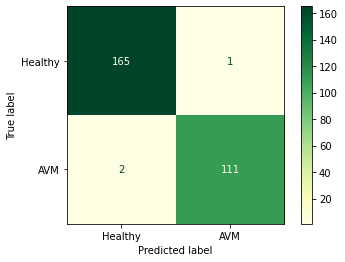

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label_names)
disp.plot(cmap='YlGn')

In [ ]:
#TRUE POSITIVES
isel_tp_CNN_amp = np.where((y_test==1)&(y_test_pred_DL_full_CNN_amp==1))
isel_tp_CNN_amp = np.squeeze(isel_tp_CNN_amp)
#TRUE NEGATIVES
isel_tn_CNN_amp = np.where((y_test==0)&(y_test_pred_DL_full_CNN_amp==0))
isel_tn_CNN_amp = np.squeeze(isel_tn_CNN_amp)
#FALSE POSITIVES
isel_fp_CNN_amp = np.where((y_test==0)&(y_test_pred_DL_full_CNN_amp==1))
isel_fp_CNN_amp = np.squeeze(isel_fp_CNN_amp)
#FALSE NEGATIVES
isel_fn_CNN_amp = np.where((y_test==1)&(y_test_pred_DL_full_CNN_amp==0))
isel_fn_CNN_amp = np.squeeze(isel_fn_CNN_amp)

**FALSE POSITIVES**

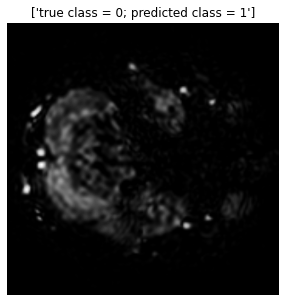

<Figure size 1296x576 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(5, 5))
k=isel_fp_CNN_amp
plt.imshow(np.squeeze(x_test[k]),cmap=plt.cm.gray)
plt.title(['true class = {}; predicted class = {}'.format(y_test[k],y_test_pred_DL_full_CNN_amp[k])])
plt.axis('off')
fig = plt.figure(figsize=(18, 8))


**FALSE NEGATIVES**

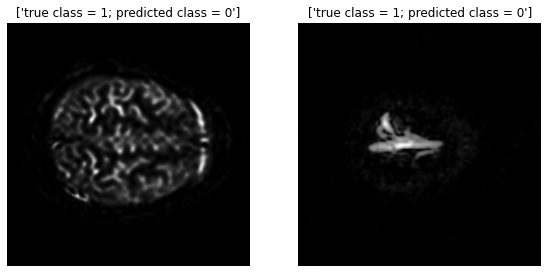

In [ ]:
fig = plt.figure(figsize=(20, 20))

cnt = 0
for k in isel_fn_CNN_amp:
    cnt += 1
    ax = fig.add_subplot(3, 4,cnt)
    ax.imshow(np.squeeze(x_test[k]),cmap=plt.cm.gray)
    ax.set_title(['true class = {}; predicted class = {}'.format(y_test[k],y_test_pred_DL_full_CNN_amp[k])])
    ax.axis('off')

## VGG16

VGG16 is a CNN architecture developed by Simonyan and Zisserman in 2014. Source: https://arxiv.org/abs/1409.1556

In [ ]:
import keras, os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

vgg16 = Sequential()
# Block 1
vgg16.add(Conv2D(input_shape=(320,320,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vgg16.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vgg16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# Block 2
vgg16.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg16.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# Block 3
vgg16.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# Block 4
vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# Block 5
vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# Fully connected layers
vgg16.add(Flatten())
vgg16.add(Dense(units=4096,activation="relu"))
vgg16.add(Dense(units=4096,activation="relu"))
vgg16.add(Dense(units=2, activation="softmax"))

vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

vgg16.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 320, 320, 64)      640       
                                                                 
 conv2d_6 (Conv2D)           (None, 320, 320, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 160, 160, 64)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 160, 160, 128)     73856     
                                                                 
 conv2d_8 (Conv2D)           (None, 160, 160, 128)     147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 80, 80, 128)      0         
 2D)                                                  

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# UNCOMMENT TO TRAIN THE MODEL
#filepath=path+'models/vgg16.h5'

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,  save_best_only=True, mode='min')
#history_vgg16=vgg16.fit(x_train,y_train_cat,batch_size=32, validation_split=0.1,epochs=100,callbacks=[checkpoint])

Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 0.6773 - accuracy: 0.5925
Epoch 1: val_loss improved from inf to 0.71758, saving model to /content/drive/MyDrive/Pràctiques SJD Júlia i Clara/IA/vgg16.h5
19/19 [==============================] - 88s 4s/step - loss: 0.6773 - accuracy: 0.5925 - val_loss: 0.7176 - val_accuracy: 0.4769
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6768 - accuracy: 0.5925
Epoch 2: val_loss did not improve from 0.71758
19/19 [==============================] - 16s 815ms/step - loss: 0.6768 - accuracy: 0.5925 - val_loss: 0.7185 - val_accuracy: 0.4769
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6765 - accuracy: 0.5925
Epoch 3: val_loss improved from 0.71758 to 0.71516, saving model to /content/drive/MyDrive/Pràctiques SJD Júlia i Clara/IA/vgg16.h5
19/19 [==============================] - 30s 2s/step - loss: 0.6765 - accuracy: 0.5925 - val_loss: 0.7152 - val_accuracy: 0.4769
Epoch 4/100
19

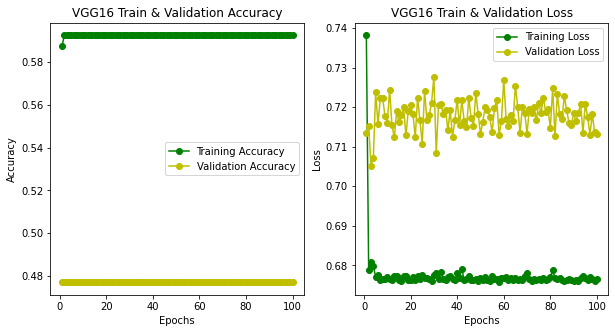

In [ ]:
#Plot the training artifacts
fig , ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

train_acc = history_vgg16.history['accuracy']
train_loss = history_vgg16.history['loss']
val_acc = history_vgg16.history['val_accuracy']
val_loss = history_vgg16.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs, train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('VGG16 Train & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs, val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('VGG16 Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

In [ ]:
# Load weights
filepath=path+'models/vgg16.h5'
vgg16.load_weights(filepath)

#Evaluate
score = vgg16.evaluate(x_test, y_test_cat, verbose=2)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
label_names = ['Healthy', 'AVM']
# Confussion matrix
y_test_pred_DL_full = np.argmax(vgg16.predict(x_test),axis=1) # convert back from one-hot categorical encoding to integers
print(classification_report(y_test, y_test_pred_DL_full, target_names=label_names))
cm_vgg16=confusion_matrix(y_test, y_test_pred_DL_full)
print(cm_vgg16)

9/9 - 11s - loss: 0.6760 - accuracy: 0.5950 - 11s/epoch - 1s/step
Test loss: 0.6759690642356873
Test accuracy: 0.5949820876121521
9/9 [==============================] - 2s 284ms/step
              precision    recall  f1-score   support

     Healthy       0.59      1.00      0.75       166
         AVM       0.00      0.00      0.00       113

    accuracy                           0.59       279
   macro avg       0.30      0.50      0.37       279
weighted avg       0.35      0.59      0.44       279

[[166   0]
 [113   0]]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


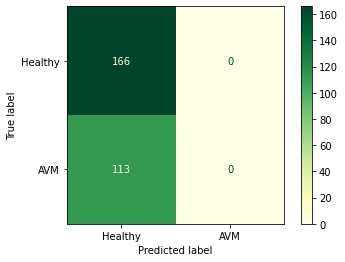

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm_vgg16,display_labels=label_names)
disp.plot(cmap='YlGn')


##ALEXNET

AlexNet is a model architecture designed by Alex Krizhevsky in collaboration with Ilya Sutskever and Geoffrey Hinton. 

In [ ]:
alexnet = keras.models.Sequential([
    # Block 1
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(320,320,1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    # Block 2 original kernel_size (5,5)
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    # Block 3
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    # Block 4
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    # Block 5
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    # fully connected layers
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

alexnet.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

alexnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 78, 78, 96)        11712     
                                                                 
 batch_normalization (BatchN  (None, 78, 78, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 38, 38, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 38, 38, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 38, 38, 256)      1024      
 hNormalization)                                                 
                                                      

In [ ]:
#Uncomment to train
#batch_size =32 
#filepath=path+'models/alexnet_.h5'
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#history_alexnet=alexnet.fit(x_train, y_train_cat, batch_size=batch_size, epochs=50, validation_split=0.1,callbacks=checkpoint)

Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 37.3110 - accuracy: 0.7997
Epoch 1: val_loss improved from inf to 87.63985, saving model to /content/drive/MyDrive/Pràctiques SJD Júlia i Clara/IA/alexnet_.h5
19/19 [==============================] - 52s 3s/step - loss: 37.3110 - accuracy: 0.7997 - val_loss: 87.6398 - val_accuracy: 0.6615
Epoch 2/50
18/19 [===========================>..] - ETA: 0s - loss: 2.4891 - accuracy: 0.9705
Epoch 2: val_loss did not improve from 87.63985
19/19 [==============================] - 2s 87ms/step - loss: 2.4550 - accuracy: 0.9709 - val_loss: 89.4791 - val_accuracy: 0.6308
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 1.3563 - accuracy: 0.9743
Epoch 3: val_loss did not improve from 87.63985
19/19 [==============================] - 2s 86ms/step - loss: 1.3563 - accuracy: 0.9743 - val_loss: 113.4818 - val_accuracy: 0.5231
Epoch 4/50
18/19 [===========================>..] - ETA: 0s - loss: 1.3965 - accuracy: 0.9722

In [ ]:
history_alexnet=alexnet.fit(x_train, y_train_cat, batch_size=32, epochs=50, validation_split=0.1)

Epoch 1/50
19/19 [==============================] - 7s 231ms/step - loss: 24.4205 - accuracy: 0.8493 - val_loss: 19.3245 - val_accuracy: 0.8154
Epoch 2/50
19/19 [==============================] - 2s 90ms/step - loss: 1.7267 - accuracy: 0.9777 - val_loss: 57.4963 - val_accuracy: 0.6923
Epoch 3/50
19/19 [==============================] - 2s 85ms/step - loss: 2.5402 - accuracy: 0.9726 - val_loss: 213.3162 - val_accuracy: 0.5231
Epoch 4/50
19/19 [==============================] - 2s 91ms/step - loss: 2.0326 - accuracy: 0.9675 - val_loss: 327.7440 - val_accuracy: 0.5231
Epoch 5/50
19/19 [==============================] - 2s 93ms/step - loss: 1.5057 - accuracy: 0.9880 - val_loss: 152.4041 - val_accuracy: 0.5231
Epoch 6/50
19/19 [==============================] - 2s 85ms/step - loss: 1.0277 - accuracy: 0.9777 - val_loss: 422.3388 - val_accuracy: 0.5231
Epoch 7/50
19/19 [==============================] - 2s 86ms/step - loss: 2.3431 - accuracy: 0.9709 - val_loss: 440.4123 - val_accuracy: 0.5231

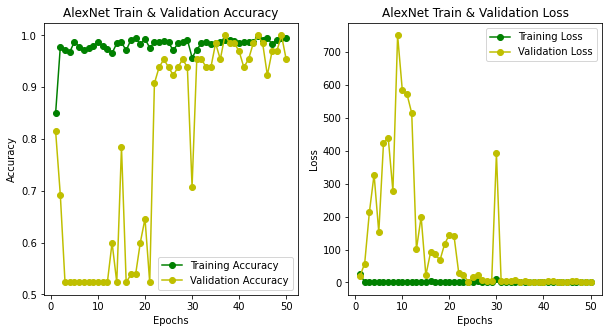

In [ ]:
#Plot the training artifacts
fig , ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

train_acc = history_alexnet.history['accuracy']
train_loss = history_alexnet.history['loss']
val_acc = history_alexnet.history['val_accuracy']
val_loss = history_alexnet.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs, train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('AlexNet Train & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs, val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('AlexNet Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Load weights
filepath=path+'models/alexnet_.h5'
alexnet.load_weights(filepath)

# Evaluate the model
score = alexnet.evaluate(x_test, y_test_cat, verbose=2)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
label_names = ['Healthy', 'AVM']

#Classification matrix
y_test_pred_DL_full_alexnet= np.argmax(alexnet.predict(x_test),axis=1) # convert back from one-hot categorical encoding to integers
print(classification_report(y_test, y_test_pred_DL_full_alexnet, target_names=label_names))
cm_alexnet=confusion_matrix(y_test, y_test_pred_DL_full_alexnet)
print(cm_alexnet)

9/9 - 3s - loss: 2.0331 - accuracy: 0.9857 - 3s/epoch - 326ms/step
Test loss: 2.0330629348754883
Test accuracy: 0.9856630563735962
9/9 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

     Healthy       0.98      1.00      0.99       166
         AVM       1.00      0.96      0.98       113

    accuracy                           0.99       279
   macro avg       0.99      0.98      0.99       279
weighted avg       0.99      0.99      0.99       279

[[166   0]
 [  4 109]]


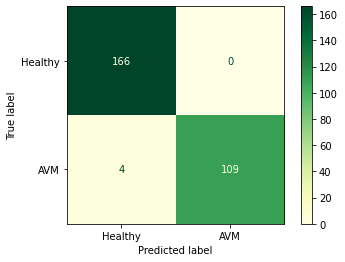

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm_alexnet,display_labels=label_names)
disp.plot(cmap='YlGn')


In [ ]:
#TRUE POSITIVES
isel_tp_alexnet = np.where((y_test==1)&(y_test_pred_DL_full_alexnet==1))
isel_tp_alexnet = np.squeeze(isel_tp_alexnet)
#TRUE NEGATIVES
isel_tn_alexnet = np.where((y_test==0)&(y_test_pred_DL_full_alexnet==0))
isel_tn_alexnet = np.squeeze(isel_tn_alexnet)
#FALSE POSITIVES
isel_fp_alexnet = np.where((y_test==0)&(y_test_pred_DL_full_alexnet==1))
isel_fp_alexnet = np.squeeze(isel_fp_alexnet)
#FALSE NEGATIVES
isel_fn_alexnet = np.where((y_test==1)&(y_test_pred_DL_full_alexnet==0))
isel_fn_alexnet = np.squeeze(isel_fn_alexnet)

**FALSE NEGATIVES**

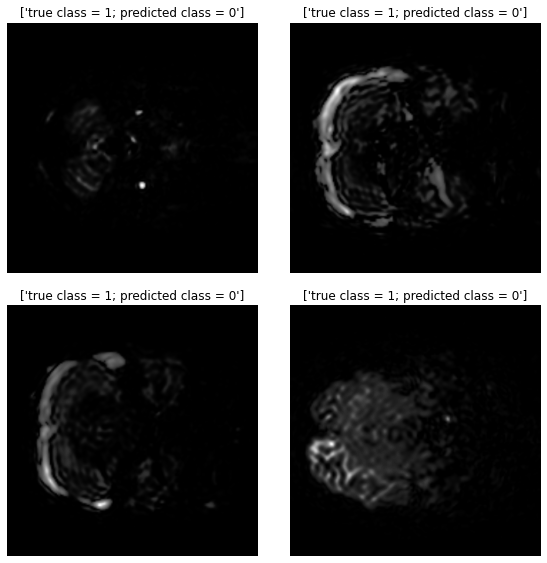

In [ ]:
fig = plt.figure(figsize=(8, 8))

cnt = 0
for k in isel_fn_alexnet:
    cnt += 1
    ax = fig.add_subplot(2, 2,cnt)
    ax.imshow(np.squeeze(x_test[k]),cmap=plt.cm.gray)
    ax.set_title(['true class = {}; predicted class = {}'.format(y_test[k],y_test_pred_DL_full_alexnet[k])])
    ax.axis('off')
fig.tight_layout()

## AlexNet Red

Next, another AlexNet architecture is defined, simplifying the first one by only mantaining the two first convolutional blocks.

In [ ]:
alexnet_red = keras.models.Sequential([
    # Block 1 
    keras.layers.Conv2D(filters=96, kernel_size=(5,5), strides=(2,2), activation='relu', input_shape=(320,320,1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    # Block 2 original kernel_size (5,5)
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),

    keras.layers.Flatten(),
    # fully connected layers

    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

alexnet_red.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

alexnet_red.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 158, 158, 96)      2496      
                                                                 
 batch_normalization_5 (Batc  (None, 158, 158, 96)     384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 78, 78, 96)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 78, 78, 256)       221440    
                                                                 
 batch_normalization_6 (Batc  (None, 78, 78, 256)      1024      
 hNormalization)                                                 
                                                      

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Uncomment to train the model

#batch_size =32 
#epochs = 50
#filepath=path+'models/alexnet_red.h5'
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#history_alexnet_red=alexnet_red.fit(x_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.1,callbacks=checkpoint)

Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 9.7056 - accuracy: 0.8579
Epoch 1: val_loss improved from inf to 5.75686, saving model to /content/drive/MyDrive/Pràctiques SJD Júlia i Clara/IA/alexnet_red.h5
19/19 [==============================] - 6s 253ms/step - loss: 9.7056 - accuracy: 0.8579 - val_loss: 5.7569 - val_accuracy: 0.5385
Epoch 2/50
18/19 [===========================>..] - ETA: 0s - loss: 1.2084 - accuracy: 0.9774
Epoch 2: val_loss did not improve from 5.75686
19/19 [==============================] - 2s 126ms/step - loss: 1.1918 - accuracy: 0.9777 - val_loss: 20.0904 - val_accuracy: 0.5231
Epoch 3/50
18/19 [===========================>..] - ETA: 0s - loss: 0.7425 - accuracy: 0.9931
Epoch 3: val_loss did not improve from 5.75686
19/19 [==============================] - 2s 126ms/step - loss: 0.7324 - accuracy: 0.9932 - val_loss: 26.8704 - val_accuracy: 0.5231
Epoch 4/50
18/19 [===========================>..] - ETA: 0s - loss: 0.3634 - accuracy: 0.9896

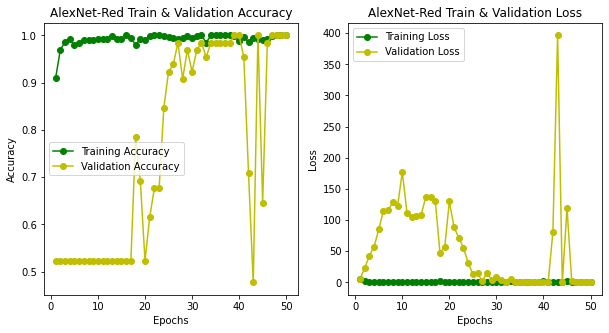

In [ ]:
#Plot the training artifacts
fig , ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

train_acc = history_alexnet_red.history['accuracy']
train_loss = history_alexnet_red.history['loss']
val_acc = history_alexnet_red.history['val_accuracy']
val_loss = history_alexnet_red.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs, train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('AlexNet-Red Train & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs, val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('AlexNet-Red Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Restore the weights
filepath=path+'models/alexnet_red.h5'
alexnet_red.load_weights(filepath)

# Evaluate the model
score = alexnet_red.evaluate(x_test, y_test_cat, verbose=2)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
label_names = ['Healthy', 'AVM']
# Make predictions
y_test_pred_DL_full_alexnet_red = np.argmax(alexnet_red.predict(x_test),axis=1) # convert back from one-hot categorical encoding to integers

# Classification metrics
print(classification_report(y_test, y_test_pred_DL_full_alexnet_red, target_names=label_names))
cm=confusion_matrix(y_test, y_test_pred_DL_full_alexnet_red)
print(cm)

9/9 - 2s - loss: 1.0102 - accuracy: 0.9928 - 2s/epoch - 268ms/step
Test loss: 1.0101566314697266
Test accuracy: 0.9928315281867981
9/9 [==============================] - 0s 41ms/step
              precision    recall  f1-score   support

     Healthy       0.99      0.99      0.99       166
         AVM       0.99      0.99      0.99       113

    accuracy                           0.99       279
   macro avg       0.99      0.99      0.99       279
weighted avg       0.99      0.99      0.99       279

[[165   1]
 [  1 112]]


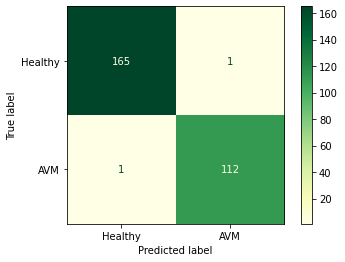

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label_names)
disp.plot(cmap='YlGn')

In [ ]:
#TRUE POSITIVES
isel_tp_alexnet_red = np.where((y_test==1)&(y_test_pred_DL_full_alexnet_red==1))
isel_tp_alexnet_red = np.squeeze(isel_tp_alexnet_red)
#TRUE NEGATIVES
isel_tn_alexnet_red = np.where((y_test==0)&(y_test_pred_DL_full_alexnet_red==0))
isel_tn_alexnet_red= np.squeeze(isel_tn_alexnet_red)
#FALSE POSITIVES
isel_fp_alexnet_red = np.where((y_test==0)&(y_test_pred_DL_full_alexnet_red==1))
isel_fp_alexnet_red = np.squeeze(isel_fp_alexnet_red)
#FALSE NEGATIVES
isel_fn_alexnet_red = np.where((y_test==1)&(y_test_pred_DL_full_alexnet_red==0))
isel_fn_alexnet_red = np.squeeze(isel_fn_alexnet_red)

**FALSE NEGATIVE**

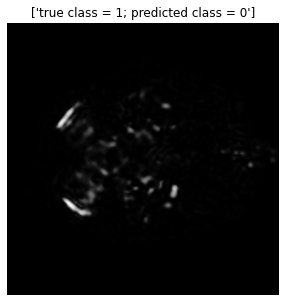

<Figure size 1296x576 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(5, 5))
k=isel_fn_alexnet_red
plt.imshow(np.squeeze(x_test[k]),cmap=plt.cm.gray)
plt.title(['true class = {}; predicted class = {}'.format(y_test[k],y_test_pred_DL_full_alexnet_red[k])])
plt.axis('off')
fig = plt.figure(figsize=(18, 8))

**FALSE POSITIVE**

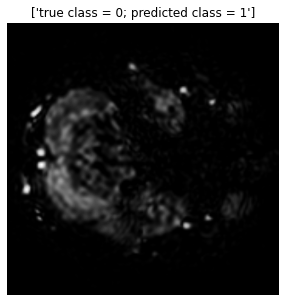

<Figure size 1296x576 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(5, 5))
k=isel_fp_alexnet_red
plt.imshow(np.squeeze(x_test[k]),cmap=plt.cm.gray)
plt.title(['true class = {}; predicted class = {}'.format(y_test[k],y_test_pred_DL_full_alexnet_red[k])])
plt.axis('off')
fig = plt.figure(figsize=(18, 8))

# Explainability: GradCAM

The GradCAM function is used as an explainability method to understand the models decisions. GradCAM funtion uses the gradients flowing to a convolutional layer to provide explainable feature maps. The function used in this notebook is extracted from the library tf-explain

In [ ]:
%pip install tf-explain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.2 MB/s 


In [ ]:
#importació de paquets necessaris
from tf_explain.core.activations import ExtractActivations
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.integrated_gradients import IntegratedGradients
import cv2

GradCAM is applied then first to the last convolutional layer of each model, except from VGG16 as its results do not make them a good classified in this case.

### CNN

In [ ]:
# Remove last layer's softmax
CNN.layers[-1].activation = None
last_layer_name_cnn='conv2d_1'

First, the correct classified cases are shown to observe in which features the model bases its prediction to determine a pathologic and no-pathologic output.

**TRUE POSITIVES**

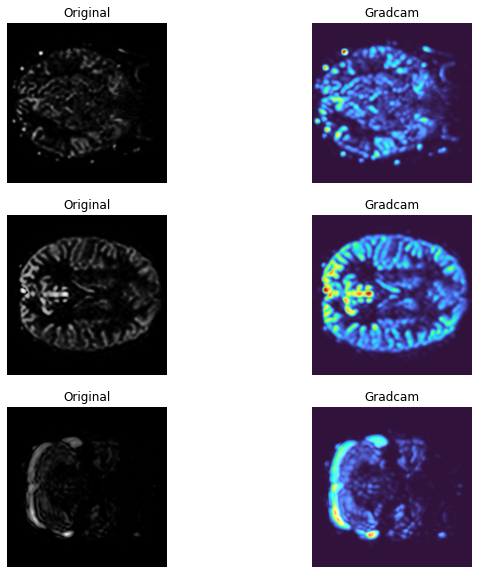

In [ ]:
img_width=320
img_height=320

list_GradCAM2=isel_tp_CNN[51:54]

fig,ax=plt.subplots(len(list_GradCAM2),2,figsize=(10,10))
cnt=0

for i in range(len(list_GradCAM2)):
    cnt += 1
    image = x_test[list_GradCAM2[i]]
    X=image.reshape(1,320,320,1)
    Y=y_test_pred_DL_full_CNN[list_GradCAM2[i]]

    explainer = GradCAM()
    output= explainer.explain(
        validation_data=(X, None),
        model=CNN,
        layer_name=last_layer_name_cnn,
        class_index=Y,
        colormap=cv2.COLORMAP_TURBO
    )
    
    ax[i,0].imshow(np.squeeze(image),cmap='gray')
    ax[i,0].axis('off')
    ax[i,0].set_title('Original')
    ax[i,1].imshow(output)
    ax[i,1].axis('off')
    ax[i,1].set_title('Gradcam')
  
plt.show()
fig.tight_layout()

**TRUE NEGATIVES**

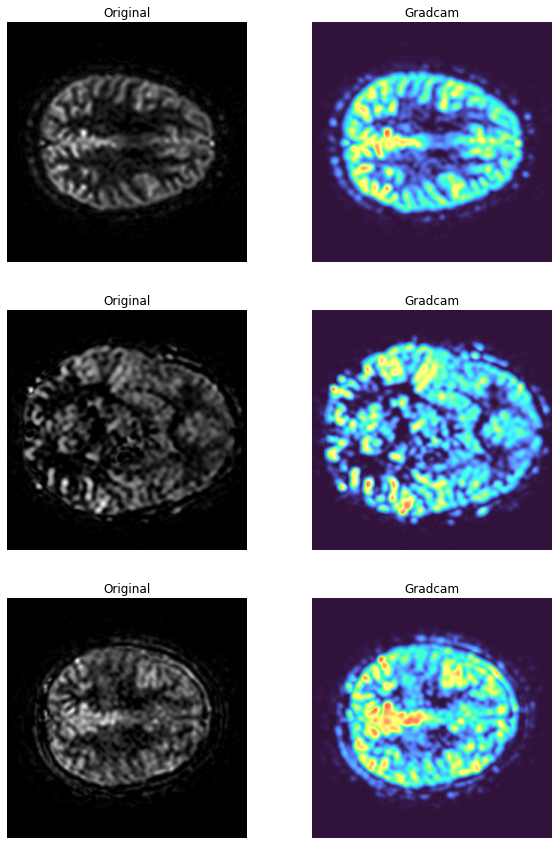

In [ ]:
list_GradCAM2=isel_tn_CNN[10:13]

fig,ax=plt.subplots(len(list_GradCAM2),2,figsize=(10,15))
cnt=0

for i in range(len(list_GradCAM2)):
    cnt += 1
    image = x_test[list_GradCAM2[i]]
    X=image.reshape(1,320,320,1)
    Y=y_test_pred_DL_full_CNN[list_GradCAM2[i]]

    explainer = GradCAM()
    output= explainer.explain(
        validation_data=(X, None),
        model=CNN,
        layer_name=last_layer_name_cnn,
        class_index=Y,
        colormap=cv2.COLORMAP_TURBO
    )
    ax[i,0].imshow(np.squeeze(image),cmap='gray')
    ax[i,0].axis('off')
    ax[i,0].set_title('Original')
    ax[i,1].imshow(output)
    ax[i,1].axis('off')
    ax[i,1].set_title('Gradcam')
  
plt.show()
fig.tight_layout()

Then, we plot the misclassified cases.

**FALSE NEGATIVES**

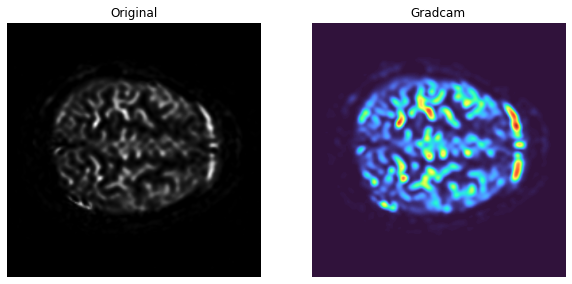

In [ ]:
list_GradCAM2=isel_fn_CNN

fig,ax=plt.subplots(1,2,figsize=(10,15))

image = x_test[list_GradCAM2]
X=image.reshape(1,320,320,1)
Y=y_test_pred_DL_full_CNN[list_GradCAM2]

explainer = GradCAM()
output= explainer.explain(validation_data=(X, None), model=CNN,layer_name=last_layer_name_cnn,class_index=Y,colormap=cv2.COLORMAP_TURBO)
ax[0].imshow(np.squeeze(image),cmap='gray')
ax[0].axis('off')
ax[0].set_title('Original')
ax[1].imshow(output)
ax[1].axis('off')
ax[1].set_title('Gradcam')
  
plt.show()
fig.tight_layout()

**FALSE POSITIVES**

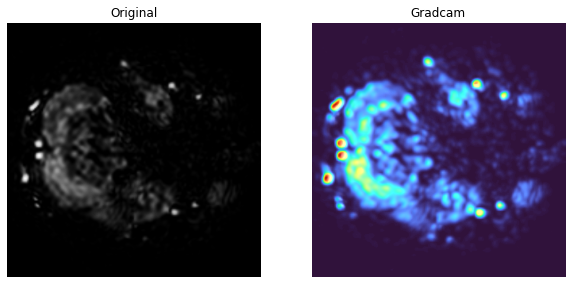

In [ ]:
list_GradCAM2=isel_fp_CNN

fig,ax=plt.subplots(1,2,figsize=(10,15))

image = x_test[list_GradCAM2]
X=image.reshape(1,320,320,1)
Y=y_test_pred_DL_full_CNN[list_GradCAM2]

explainer = GradCAM()
output= explainer.explain(validation_data=(X, Y), model=CNN,layer_name=last_layer_name_cnn,class_index=Y,colormap=cv2.COLORMAP_TURBO)
ax[0].imshow(np.squeeze(image),cmap='gray')
ax[0].axis('off')
ax[0].set_title('Original')
ax[1].imshow(output)
ax[1].axis('off')
ax[1].set_title('Gradcam')
  
plt.show()
fig.tight_layout()

The same workflow is repeated for each model:

### CNN amp

In [ ]:
# Remove last layer's softmax
CNN_amp.layers[-1].activation = None
last_layer_name='conv2d_4'

**TRUE POSITIVES**

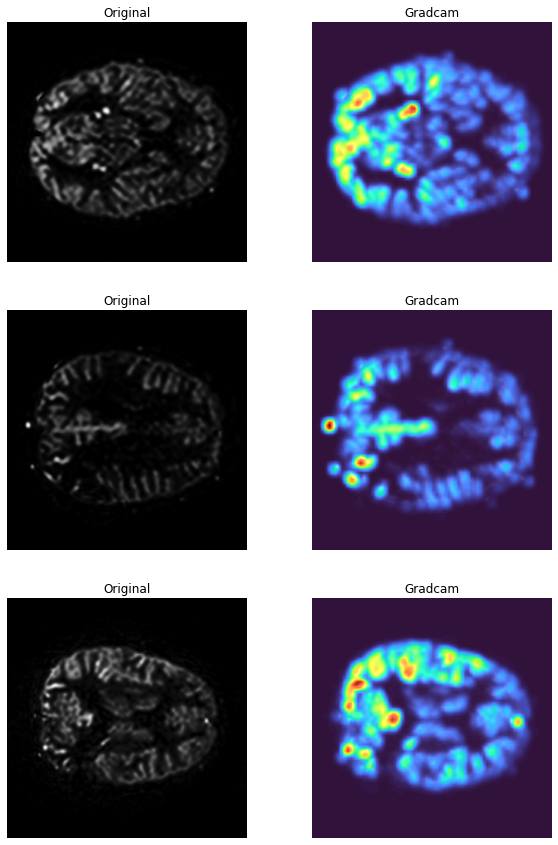

In [ ]:
list_GradCAM2=isel_tp_CNN_amp[20:23]

fig,ax=plt.subplots(len(list_GradCAM2),2,figsize=(10,15))
cnt=0

for i in range(len(list_GradCAM2)):
    cnt += 1
    image = x_test[list_GradCAM2[i]]
    X=image.reshape(1,320,320,1)
    Y=y_test_pred_DL_full_CNN_amp[list_GradCAM2[i]]

    explainer = GradCAM()
    output= explainer.explain((X, None),CNN_amp,layer_name=last_layer_name,class_index=Y,colormap=cv2.COLORMAP_TURBO)
    ax[i,0].imshow(np.squeeze(image),cmap='gray')
    ax[i,0].axis('off')
    ax[i,0].set_title('Original')
    ax[i,1].imshow(output)
    ax[i,1].axis('off')
    ax[i,1].set_title('Gradcam')
  
plt.show()
fig.tight_layout()

**TRUE NEGATIVES**

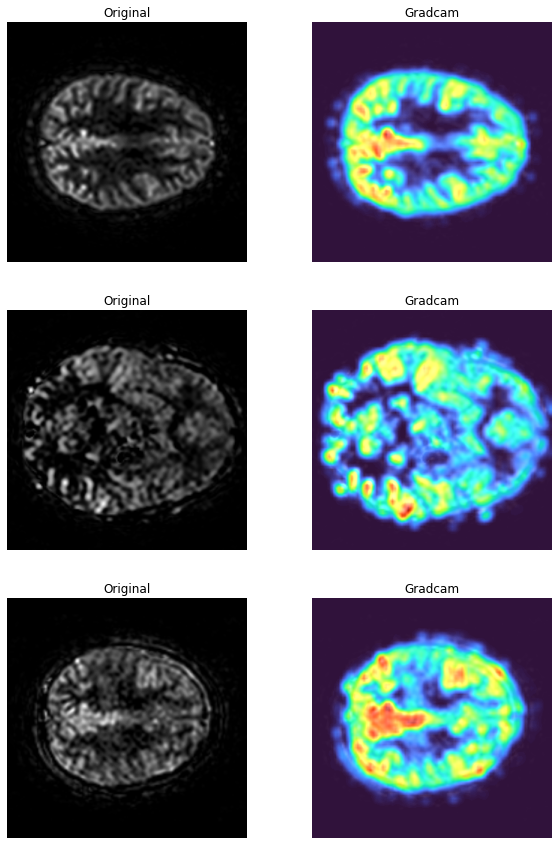

In [ ]:
list_GradCAM2=isel_tn_CNN_amp[10:13]

fig,ax=plt.subplots(len(list_GradCAM2),2,figsize=(10,15))
cnt=0

for i in range(len(list_GradCAM2)):
    cnt += 1
    image = x_test[list_GradCAM2[i]]
    X=image.reshape(1,320,320,1)
    Y=y_test_pred_DL_full_CNN_amp[list_GradCAM2[i]]

    explainer = GradCAM()
    output= explainer.explain(
        validation_data=(X, Y),
        model=CNN_amp,
        class_index=Y,
        layer_name=last_layer_name,
        colormap=cv2.COLORMAP_TURBO
    )
    ax[i,0].imshow(np.squeeze(image),cmap='gray')
    ax[i,0].axis('off')
    ax[i,0].set_title('Original')
    ax[i,1].imshow(output)
    ax[i,1].axis('off')
    ax[i,1].set_title('Gradcam')
  
plt.show()


**FALSE POSITIVES**

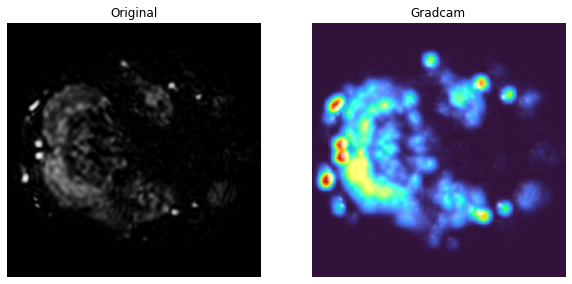

In [ ]:
list_GradCAM2=isel_fp_CNN_amp

fig,ax=plt.subplots(1,2,figsize=(10,15))

image = x_test[list_GradCAM2]
X=image.reshape(1,320,320,1)
Y=y_test_pred_DL_full_CNN_amp[list_GradCAM2]

explainer = GradCAM()
output= explainer.explain(validation_data=(X, Y), model=CNN_amp,
                          layer_name=last_layer_name,class_index=Y,
                          colormap=cv2.COLORMAP_TURBO)

ax[0].imshow(np.squeeze(image),cmap='gray')
ax[0].axis('off')
ax[0].set_title('Original')
ax[1].imshow(output)
ax[1].axis('off')
ax[1].set_title('Gradcam')
  
plt.show()
fig.tight_layout()

**FALSE NEGATIVES**

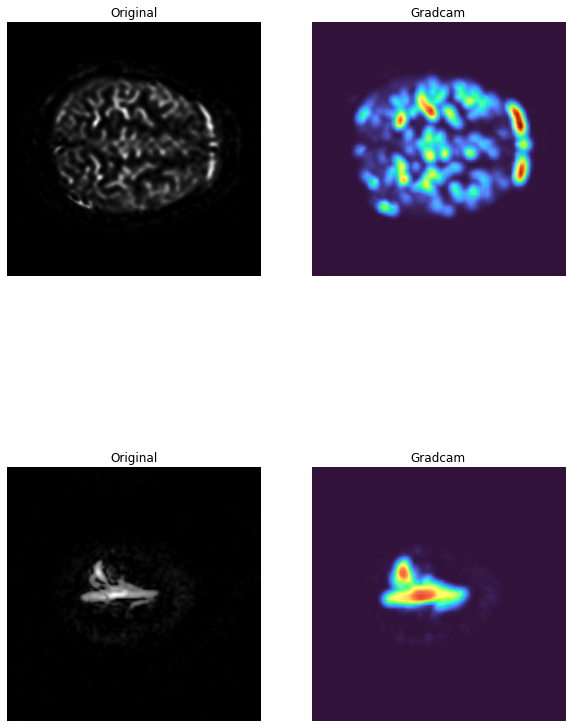

In [ ]:
list_GradCAM2=isel_fn_CNN_amp

fig,ax=plt.subplots(len(list_GradCAM2),2,figsize=(10,15))
cnt=0

for i in range(len(list_GradCAM2)):
    cnt += 1
    image = x_test[list_GradCAM2[i]]
    X=image.reshape(1,320,320,1)
    Y=y_test_pred_DL_full_CNN_amp[list_GradCAM2[i]]

    explainer = GradCAM()
    output= explainer.explain(
        validation_data=(X, Y),
        model=CNN_amp,
        class_index=Y,
        layer_name=last_layer_name,
        colormap=cv2.COLORMAP_TURBO
    )
    ax[i,0].imshow(np.squeeze(image),cmap='gray')
    ax[i,0].axis('off')
    ax[i,0].set_title('Original')
    ax[i,1].imshow(output)
    ax[i,1].axis('off')
    ax[i,1].set_title('Gradcam')
  
plt.show()

### Alexnet

In [ ]:
# Remove last layer's softmax
alexnet.layers[-1].activation = None
last_layer_name_alexnet='conv2d_9' 


**TRUE POSITIVES**

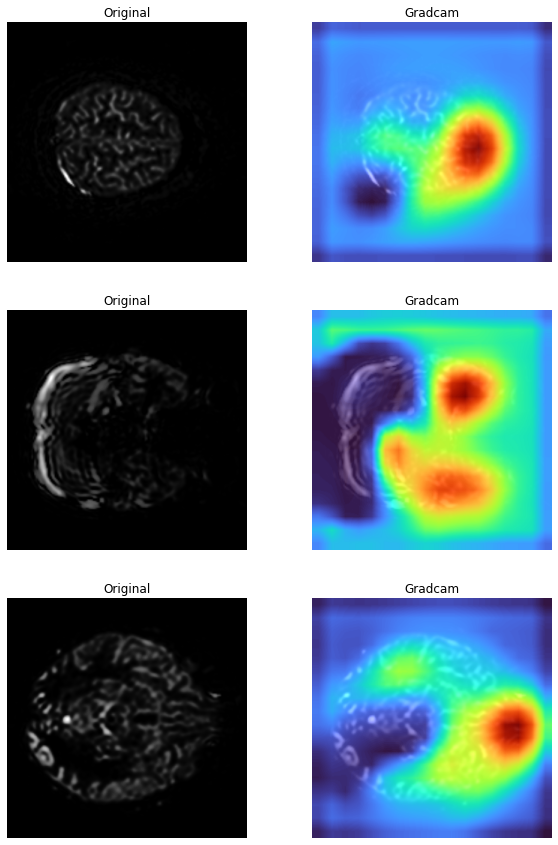

In [ ]:
list_GradCAM2=isel_tp_alexnet[40:43]

fig,ax=plt.subplots(len(list_GradCAM2),2,figsize=(10,15))
cnt=0

for i in range(len(list_GradCAM2)):
    cnt += 1
    image = x_test[list_GradCAM2[i]]
    X=image.reshape(1,320,320,1)
    Y=y_test_pred_DL_full_alexnet[list_GradCAM2[i]]


    explainer = GradCAM()
    output= explainer.explain((X, None),alexnet,layer_name=last_layer_name_alexnet,class_index=Y,colormap=cv2.COLORMAP_TURBO)
    ax[i,0].imshow(np.squeeze(image),cmap='gray')
    ax[i,0].axis('off')
    ax[i,0].set_title('Original')
    ax[i,1].imshow(output)
    ax[i,1].axis('off')
    ax[i,1].set_title('Gradcam')
  
plt.show()
fig.tight_layout()

**TRUE NEGATIVES**

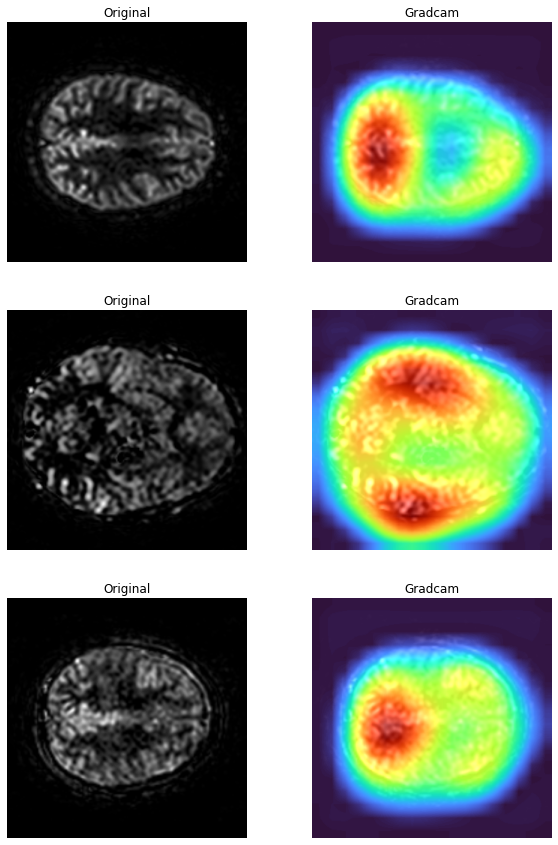

In [ ]:
list_GradCAM2=isel_tn_alexnet[10:13]

fig,ax=plt.subplots(len(list_GradCAM2),2,figsize=(10,15))
cnt=0

for i in range(len(list_GradCAM2)):
    cnt += 1
    image = x_test[list_GradCAM2[i]]
    X=image.reshape(1,320,320,1)
    Y=y_test_pred_DL_full_alexnet[list_GradCAM2[i]]

    explainer = GradCAM()
    output= explainer.explain(
        validation_data=(X, None),
        model=alexnet,
        class_index=Y,
        layer_name=last_layer_name_alexnet,
        colormap=cv2.COLORMAP_TURBO
    )
    ax[i,0].imshow(np.squeeze(image),cmap='gray')
    ax[i,0].axis('off')
    ax[i,0].set_title('Original')
    ax[i,1].imshow(output)
    ax[i,1].axis('off')
    ax[i,1].set_title('Gradcam')
  
plt.show()


**FALSE NEGATIVES**

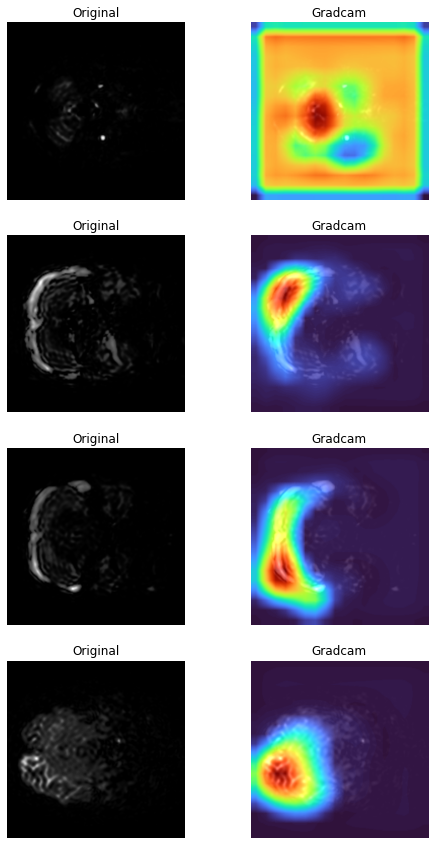

In [ ]:
list_GradCAM2=isel_fn_alexnet

fig,ax=plt.subplots(len(list_GradCAM2),2,figsize=(8,15))
cnt=0

for i in range(len(list_GradCAM2)):
    cnt += 1
    image = x_test[list_GradCAM2[i]]
    X=image.reshape(1,320,320,1)
    Y=y_test_pred_DL_full_alexnet[list_GradCAM2[i]]

    explainer = GradCAM()
    output= explainer.explain(
        validation_data=(X, None),
        model=alexnet,
        class_index=Y,
        layer_name=last_layer_name_alexnet,
        colormap=cv2.COLORMAP_TURBO
    )
    ax[i,0].imshow(np.squeeze(image),cmap='gray')
    ax[i,0].axis('off')
    ax[i,0].set_title('Original')
    ax[i,1].imshow(output)
    ax[i,1].axis('off')
    ax[i,1].set_title('Gradcam')
  
plt.show()


### Alexnet red

In [ ]:
# Remove last layer's softmax
alexnet_red.layers[-1].activation = None
last_layer_name_alexnet='conv2d_11'

**TRUE POSITIVES**

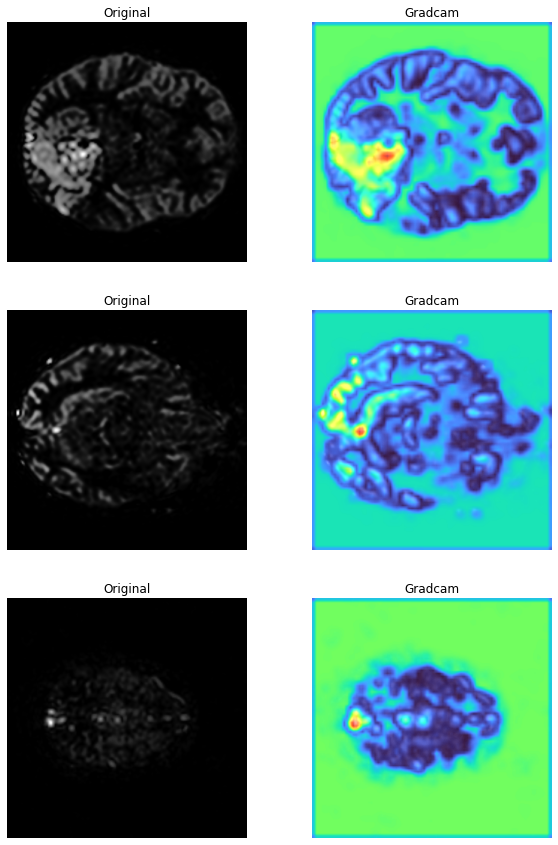

In [ ]:
list_GradCAM2=isel_tp_alexnet_red[32:35]

fig,ax=plt.subplots(len(list_GradCAM2),2,figsize=(10,15))
cnt=0

for i in range(len(list_GradCAM2)):
    cnt += 1
    image = x_test[list_GradCAM2[i]]
    X=image.reshape(1,320,320,1)
    Y=y_test_pred_DL_full_alexnet_red[list_GradCAM2[i]]

    explainer = GradCAM()
    output= explainer.explain((X, None),alexnet_red,layer_name=last_layer_name_alexnet,class_index=Y,colormap=cv2.COLORMAP_TURBO)
    ax[i,0].imshow(np.squeeze(image),cmap='gray')
    ax[i,0].axis('off')
    ax[i,0].set_title('Original')
    ax[i,1].imshow(output)
    ax[i,1].axis('off')
    ax[i,1].set_title('Gradcam')
  
plt.show()
fig.tight_layout()

**TRUE NEGATIVES**

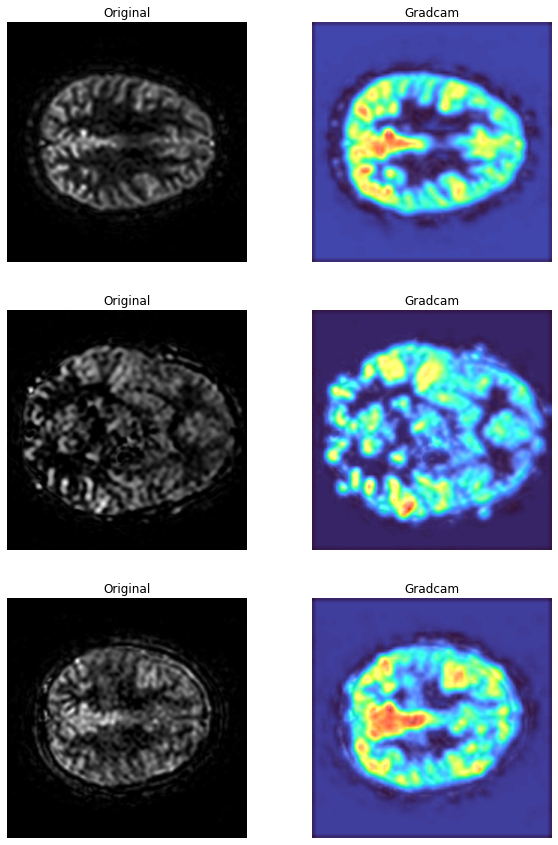

In [ ]:
list_GradCAM2=isel_tn_alexnet_red[10:13]

fig,ax=plt.subplots(len(list_GradCAM2),2,figsize=(10,15))
cnt=0

for i in range(len(list_GradCAM2)):
    cnt += 1
    image = x_test[list_GradCAM2[i]]
    X=image.reshape(1,320,320,1)
    Y=y_test_pred_DL_full_alexnet_red[list_GradCAM2[i]]

    explainer = GradCAM()
    output= explainer.explain(
        validation_data=(X, Y),
        model=alexnet_red,
        class_index= Y,
        layer_name=last_layer_name_alexnet,
        colormap=cv2.COLORMAP_TURBO
    )
    ax[i,0].imshow(np.squeeze(image),cmap='gray')
    ax[i,0].axis('off')
    ax[i,0].set_title('Original')
    ax[i,1].imshow(output)
    ax[i,1].axis('off')
    ax[i,1].set_title('Gradcam')
  
plt.show()


**FALSE NEGATIVES**

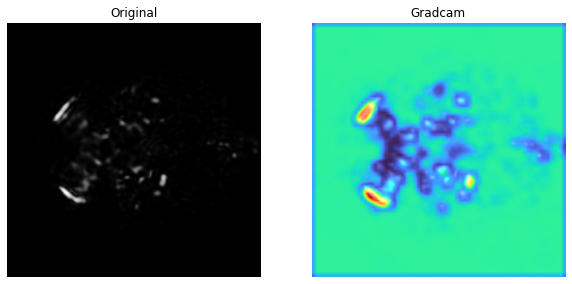

In [ ]:
list_GradCAM2=isel_fn_alexnet_red

fig,ax=plt.subplots(1,2,figsize=(10,15))

image = x_test[list_GradCAM2]
X=image.reshape(1,320,320,1)
Y=y_test_pred_DL_full_alexnet_red[list_GradCAM2]

explainer = GradCAM()
output= explainer.explain(validation_data=(X, Y), model=alexnet_red,
                          layer_name=last_layer_name_alexnet,class_index=Y,
                          colormap=cv2.COLORMAP_TURBO)

ax[0].imshow(np.squeeze(image),cmap='gray')
ax[0].axis('off')
ax[0].set_title('Original')
ax[1].imshow(output)
ax[1].axis('off')
ax[1].set_title('Gradcam')
  
plt.show()
fig.tight_layout()

**FALSE POSITIVE**

1
0


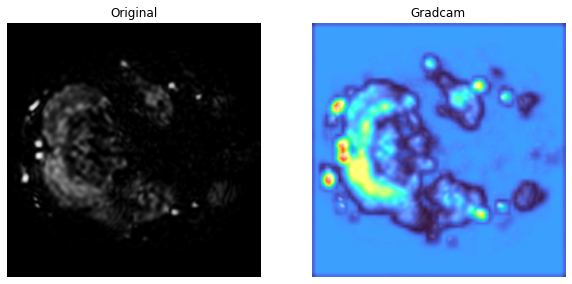

In [ ]:
list_GradCAM2=isel_fp_alexnet_red
fig,ax=plt.subplots(1,2,figsize=(10,15))

image = x_test[list_GradCAM2]
X=image.reshape(1,320,320,1)
Y=y_test_pred_DL_full_alexnet_red[list_GradCAM2]

explainer = GradCAM()
output= explainer.explain(validation_data=(X, None), model=alexnet_red,
                          layer_name=last_layer_name_alexnet,class_index=Y,
                          colormap=cv2.COLORMAP_TURBO)

ax[0].imshow(np.squeeze(image),cmap='gray')
ax[0].axis('off')
ax[0].set_title('Original')
ax[1].imshow(output)
ax[1].axis('off')
ax[1].set_title('Gradcam')
  
plt.show()
fig.tight_layout()

# GradCAM of all layers

To compare and undestand the different heatmaps obtained in AlexNet and CNN, GradCAM is used to extract the gradients of each conv layer, in correctly predicted images:


####  **CNN**

In [ ]:
## Gather all convolution from the model
## With these layers, we can explore grad-cam heatmaps for more layers in the model
conv2D_layers = [layer.name for layer in reversed(CNN.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]

**TRUE POSITIVES**

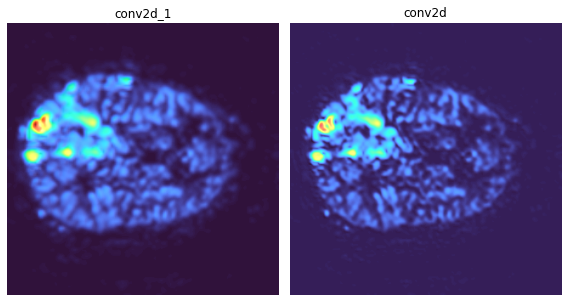

In [ ]:
## Visualizing Convolution layers
list_GradCAM2=isel_tp_CNN[0]
image = x_test[list_GradCAM2]
X=image.reshape(1,320,320,1)
Y=y_test[list_GradCAM2]

plt.figure(figsize=(8, 8))
for i, layer in enumerate(conv2D_layers):
  explainer = GradCAM()
  output= explainer.explain((X, None),CNN,layer_name=layer,class_index=Y,colormap=cv2.COLORMAP_TURBO)
  ax = plt.subplot(1, 2, i +1)
  plt.imshow(output)
  plt.title(layer)
  plt.axis("off")

plt.tight_layout()

**TRUE NEGATIVES**

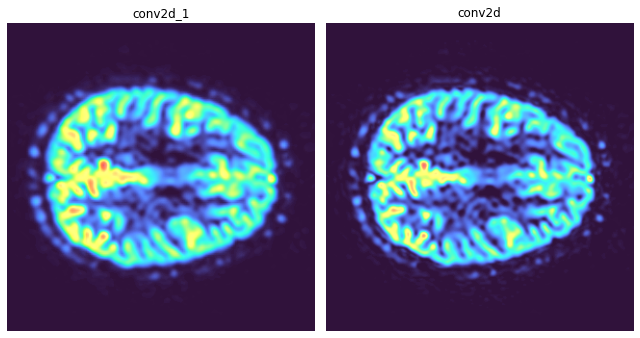

In [ ]:
## Visualizing Convolution layers
list_GradCAM2=isel_tn_CNN[10]
image = x_test[list_GradCAM2]
X=image.reshape(1,320,320,1)
Y=y_test[list_GradCAM2]

plt.figure(figsize=(9, 9))
for i, layer in enumerate(conv2D_layers):
  explainer = GradCAM()
  output= explainer.explain((X, None),CNN,layer_name=layer,class_index=Y,colormap=cv2.COLORMAP_TURBO)
  ax = plt.subplot(1, 2, i +1)
  plt.imshow(output)
  plt.title(layer)
  plt.axis("off")

plt.tight_layout()


#### **AlexNet**

In [ ]:
## Gather all convolution from the model
## With these layers, we can explore grad-cam heatmaps for more layers in the model

conv2D_layers = [layer.name for layer in reversed(alexnet.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]

**TRUE POSITIVES**

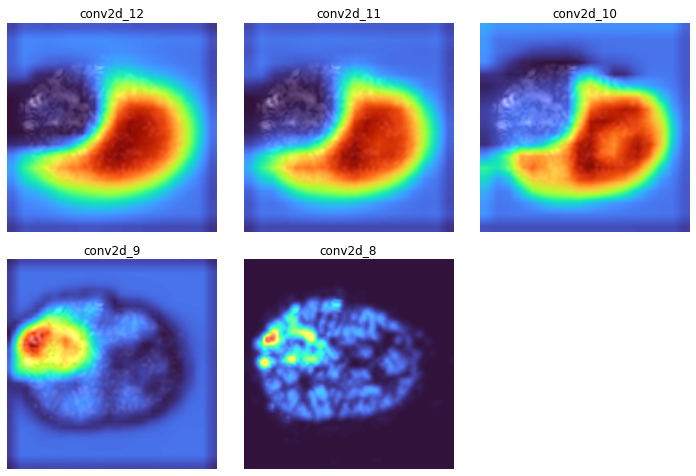

In [ ]:
## Visualizing Convolution layers
list_GradCAM2=isel_tp_alexnet[0]
image = x_test[list_GradCAM2]
X=image.reshape(1,320,320,1)
Y=y_test[list_GradCAM2]

plt.figure(figsize=(10, 10))
for i, layer in enumerate(conv2D_layers):
  explainer = GradCAM()
  output= explainer.explain((X, None),alexnet,layer_name=layer,class_index=Y,colormap=cv2.COLORMAP_TURBO)
  ax = plt.subplot(3, 3, i +1)
  plt.imshow(output)
  plt.title(layer)
  plt.axis("off")

plt.tight_layout()

**TRUE NEGATIVES**

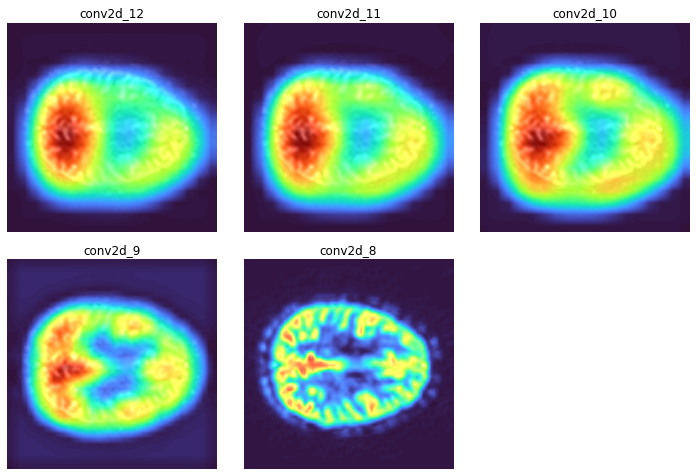

In [ ]:
## Visualizing Convolution layers
list_GradCAM2=isel_tn_alexnet[10]
image = x_test[list_GradCAM2]
X=image.reshape(1,320,320,1)
Y=y_test[list_GradCAM2]

plt.figure(figsize=(10, 10))
for i, layer in enumerate(conv2D_layers):
  explainer = GradCAM()
  output= explainer.explain((X, None),alexnet,layer_name=layer,class_index=Y,colormap=cv2.COLORMAP_TURBO)
  ax = plt.subplot(3, 3, i +1)
  plt.imshow(output)
  plt.title(layer)
  plt.axis("off")

plt.tight_layout()

#  GradCAM applied to biased images

The images used for train and test data are modified, and a watermark is added:
- An *H* to healthy images 
- A *P* for pathologic AVM imageds

In [ ]:
import cv2
images_normal_text=[]
for i in range(len(images_normal)):
  imageText = images_normal[i].copy()
  text = 'H'
  org = (250,50)
  img=cv2.putText(imageText, text, org, fontFace = cv2.FONT_HERSHEY_COMPLEX, 
                  fontScale = 1.5, color = (255,0,0))
  images_normal_text.append(img)

In [ ]:
images_avm_text=[]
for i in range(len(images_avm)):
  imageText = images_avm[i].copy()
  text = 'P'
  org = (250,50)
  img=cv2.putText(imageText, text, org, fontFace = cv2.FONT_HERSHEY_COMPLEX, 
                  fontScale = 1.5,  color = (250,225,100))
  images_avm_text.append(img)


In [ ]:
images_normal_text=np.stack(images_normal_text)
images_avm_text=np.stack(images_avm_text)

Once the images are modified, it is followed the same methodology as in the original images:

In [ ]:
# create label
y_avm_text = [1] * len(images_avm_text)
# create label
y_normal_text = [0] * len(images_normal_text)

In [ ]:
x_text=np.concatenate((images_normal_text, images_avm_text), axis=0)
y_text=np.concatenate((y_normal_text, y_avm_text), axis=0)

Data split into train and test:

In [ ]:
from sklearn.model_selection import train_test_split
x_train_text, x_test_text, y_train_text, y_test_text = train_test_split(x_text, y_text, random_state=0,train_size=0.7)

In [ ]:
num_classes=2
# convert class vectors to binary class matrices
y_train_cat_text = keras.utils.to_categorical(y_train_text, num_classes)
y_test_cat_text = keras.utils.to_categorical(y_test_text, num_classes)

In [ ]:
# Scale images to the [0, 1] range
x_train_text = x_train_text.astype("float32") / 255
x_test_text = x_test_text.astype("float32") / 255

# Expand dimensions
x_train_text = np.expand_dims(x_train_text, -1)
x_test_text = np.expand_dims(x_test_text, -1)
print("x_train_text shape:", x_train_text.shape)
print(x_train_text.shape[0], "train_text samples")
print(x_test_text.shape[0], "test_text samples")

x_train_text shape: (649, 320, 320, 1)
649 train_text samples
279 test_text samples


AlexNet and CNN models are trained again with these different images

## AlexNet

In [ ]:
alexnet2 = keras.models.Sequential([
    # Block 1
    keras.layers.Conv2D(filters=96, kernel_size=(5,5), strides=(2,2), activation='relu', input_shape=(320,320,1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    # Block 2
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    # Block 3
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    # Block 4
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    # Block 5
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    # fully connected layers
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

alexnet2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


alexnet2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 158, 158, 96)      2496      
                                                                 
 batch_normalization_7 (Batc  (None, 158, 158, 96)     384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 78, 78, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 78, 78, 256)       221440    
                                                                 
 batch_normalization_8 (Batc  (None, 78, 78, 256)      1024      
 hNormalization)                                                 
                                                      

In [ ]:
alexnet2.fit(x_train_text, y_train_cat_text, batch_size=32, epochs=50, validation_split=0.1)
alexnet2.save(path+'models/alexnet_text.h5')

Epoch 1/50
19/19 [==============================] - 7s 298ms/step - loss: 79.2891 - accuracy: 0.8106 - val_loss: 49.4544 - val_accuracy: 0.5000
Epoch 2/50
19/19 [==============================] - 5s 276ms/step - loss: 3.7609 - accuracy: 0.9625 - val_loss: 36.5918 - val_accuracy: 0.5000
Epoch 3/50
19/19 [==============================] - 5s 275ms/step - loss: 3.2296 - accuracy: 0.9676 - val_loss: 311.6053 - val_accuracy: 0.5000
Epoch 4/50
19/19 [==============================] - 5s 282ms/step - loss: 0.4078 - accuracy: 0.9898 - val_loss: 310.7308 - val_accuracy: 0.5000
Epoch 5/50
19/19 [==============================] - 5s 277ms/step - loss: 0.6426 - accuracy: 0.9881 - val_loss: 231.2224 - val_accuracy: 0.5000
Epoch 6/50
19/19 [==============================] - 5s 274ms/step - loss: 0.5242 - accuracy: 0.9915 - val_loss: 267.1450 - val_accuracy: 0.5000
Epoch 7/50
19/19 [==============================] - 5s 274ms/step - loss: 0.1159 - accuracy: 0.9983 - val_loss: 189.6052 - val_accuracy: 

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

alexnet2.load_weights(path+'models/alexnet_text.h5')
score = alexnet2.evaluate(x_test_text, y_test_cat_text, verbose=2)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
label_names = ['Healthy', 'AVM']
y_test_pred_DL_full_alexnet_text = np.argmax(alexnet2.predict(x_test_text),axis=1) # convert back from one-hot categorical encoding to integers
print(classification_report(y_test_text, y_test_pred_DL_full_alexnet_text, target_names=label_names))
cm_alexnet_text=confusion_matrix(y_test_text, y_test_pred_DL_full_alexnet_text)
print(cm_alexnet_text)

9/9 - 6s - loss: 0.0000e+00 - accuracy: 1.0000 - 6s/epoch - 676ms/step
Test loss: 0.0
Test accuracy: 1.0
9/9 [==============================] - 1s 90ms/step
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       166
         AVM       1.00      1.00      1.00       113

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279

[[166   0]
 [  0 113]]


In [ ]:
# TRUE POSITIVES
isel_tp_alexnet_text = np.where((y_test_text==1)&(y_test_pred_DL_full_alexnet_text==1))
isel_tp_alexnet_text = np.squeeze(isel_tp_alexnet_text)
# TRUE NEGATIVES
isel_tn_alexnet_text = np.where((y_test_text==0)&(y_test_pred_DL_full_alexnet_text==0))
isel_tn_alexnet_text = np.squeeze(isel_tn_alexnet_text)

### Results

In [ ]:
# Remove last layer's softmax
alexnet2.layers[-1].activation = None
last_layer_name_alexnet_text='conv2d_16'

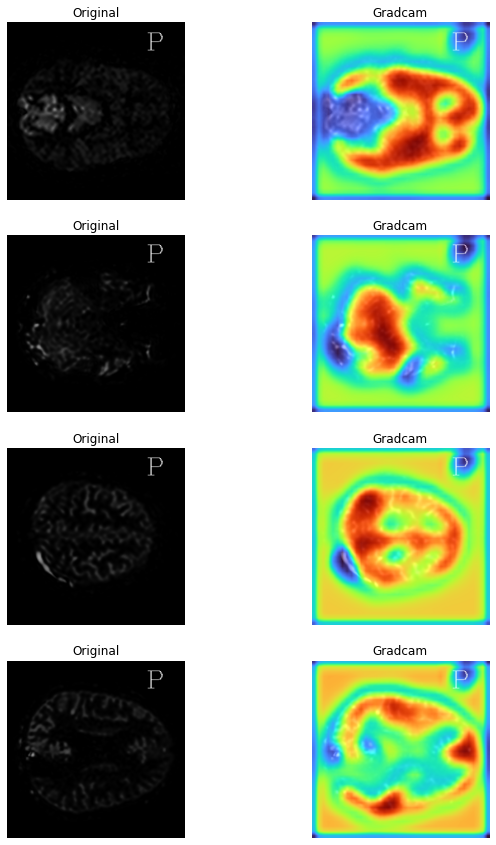

In [ ]:
# TP alexnet text
list_GradCAM2=isel_tp_alexnet_text[6:10]
fig,ax=plt.subplots(len(list_GradCAM2),2,figsize=(10,15))

for i in range(len(list_GradCAM2)):
    image = x_test_text[list_GradCAM2[i]]
    X=image.reshape(1,320,320,1)
    explainer = GradCAM()
    grid = explainer.explain((X,1),alexnet2,layer_name=last_layer_name_alexnet_text,class_index=1,colormap=cv2.COLORMAP_TURBO) 
    
    
    ax[i,0].imshow(np.squeeze(X),cmap='gray')
    ax[i,0].axis('off')
    ax[i,0].set_title('Original')
    ax[i,1].imshow(grid)
    ax[i,1].axis('off')
    ax[i,1].set_title('Gradcam')
  
plt.show()
fig.tight_layout()

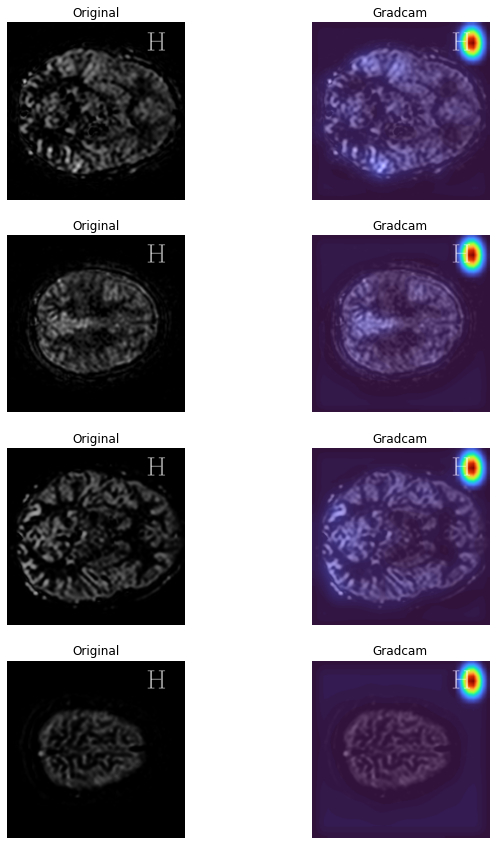

In [ ]:
# TN alexnet text
list_GradCAM2=isel_tn_alexnet_text[11:15]

fig,ax=plt.subplots(len(list_GradCAM2),2,figsize=(10,15))


for i in range(len(list_GradCAM2)):
    image = x_test_text[list_GradCAM2[i]]
    X=image.reshape(1,320,320,1)

    explainer = GradCAM()
    output= explainer.explain(
        validation_data=(X, None),
        model=alexnet2,
        layer_name=last_layer_name_alexnet_text,
        class_index=0,
        colormap=cv2.COLORMAP_TURBO
    )
    ax[i,0].imshow(np.squeeze(X),cmap='gray')
    ax[i,0].axis('off')
    ax[i,0].set_title('Original')
    ax[i,1].imshow(output)
    ax[i,1].axis('off')
    ax[i,1].set_title('Gradcam')
  
plt.show()
fig.tight_layout()

##CNN

In [ ]:
# Model / data parameters
input_shape=(320,320,1)

CNN2 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(name="features"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

CNN2.summary()

CNN2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 318, 318, 32)      320       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 159, 159, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 157, 157, 64)      18496     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 78, 78, 64)       0         
 g2D)                                                            
                                                                 
 features (Flatten)          (None, 389376)            0         
                                                                 
 dropout_18 (Dropout)        (None, 389376)          

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

batch_size =32 #32?
epochs = 20

CNN2.fit(x_train_text, y_train_cat_text, batch_size=batch_size, epochs=epochs, validation_split=0.1)
CNN2.save(path+'models/cnn_text.h5')

Epoch 1/20
19/19 [==============================] - 2s 97ms/step - loss: 0.2378 - accuracy: 0.9044 - val_loss: 0.0320 - val_accuracy: 0.9848
Epoch 2/20
19/19 [==============================] - 2s 81ms/step - loss: 0.0098 - accuracy: 0.9983 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 3/20
19/19 [==============================] - 2s 85ms/step - loss: 6.0030e-04 - accuracy: 1.0000 - val_loss: 4.9652e-04 - val_accuracy: 1.0000
Epoch 4/20
19/19 [==============================] - 2s 81ms/step - loss: 2.7160e-04 - accuracy: 1.0000 - val_loss: 3.2854e-04 - val_accuracy: 1.0000
Epoch 5/20
19/19 [==============================] - 2s 82ms/step - loss: 1.9452e-04 - accuracy: 1.0000 - val_loss: 2.5555e-04 - val_accuracy: 1.0000
Epoch 6/20
19/19 [==============================] - 2s 81ms/step - loss: 1.5974e-04 - accuracy: 1.0000 - val_loss: 2.1081e-04 - val_accuracy: 1.0000
Epoch 7/20
19/19 [==============================] - 2s 81ms/step - loss: 1.2350e-04 - accuracy: 1.0000 - val_loss: 1.7191e

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

CNN2.load_weights(path+'models/cnn_text.h5')
# Evaluate the model
score = CNN2.evaluate(x_test_text, y_test_cat_text, verbose=2)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
label_names = ['Healthy', 'AVM']
# Make predictions
y_test_pred_DL_full_CNN_text = np.argmax(CNN2.predict(x_test_text),axis=1) # convert back from one-hot categorical encoding to integers

# Classification metrics
print(classification_report(y_test_text, y_test_pred_DL_full_CNN_text, target_names=label_names))
cm=confusion_matrix(y_test_text, y_test_pred_DL_full_CNN_text)
print(cm)

9/9 - 0s - loss: 6.1642e-05 - accuracy: 1.0000 - 359ms/epoch - 40ms/step
Test loss: 6.164210208225995e-05
Test accuracy: 1.0
9/9 [==============================] - 0s 31ms/step
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       164
 Malformacio       1.00      1.00      1.00       116

    accuracy                           1.00       280
   macro avg       1.00      1.00      1.00       280
weighted avg       1.00      1.00      1.00       280

[[164   0]
 [  0 116]]


In [ ]:
#TP
isel_tp_CNN_text = np.where((y_test==1)&(y_test_pred_DL_full_CNN_text==1))
isel_tp_CNN_text = np.squeeze(isel_tp_CNN_text)
#TN
isel_tn_CNN_text = np.where((y_test==0)&(y_test_pred_DL_full_CNN_text==0))
isel_tn_CNN_text = np.squeeze(isel_tn_CNN_text)

### Results

In [ ]:
# Remove last layer's softmax
CNN2.layers[-1].activation = None
last_layer_name_cnn_text='conv2d_40'

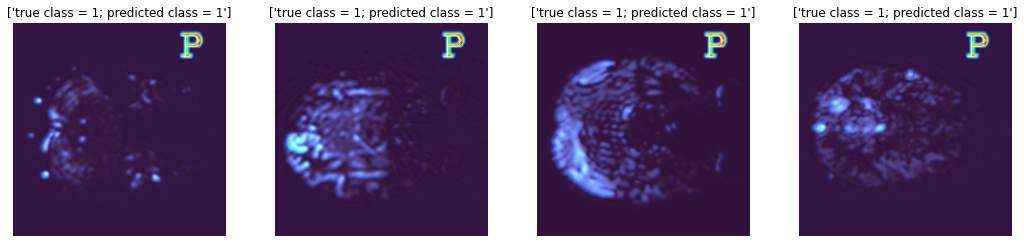

In [ ]:
#TP CNN text
img_width=320
img_height=320
fig = plt.figure(figsize=(18, 18))
cnt=0

list_GradCAM2=isel_tp_CNN_text[0:4]

for i in range(len(list_GradCAM2)):
    cnt += 1
    ax = fig.add_subplot(4, 4,cnt)
    image = x_test_text[list_GradCAM2[i]]
    X=image.reshape(1,img_width,img_height,1)
    Y=y_test_text[list_GradCAM2[i]]

    output=0
    explainer = GradCAM()
    output= explainer.explain(
        validation_data=(X, Y),
        model=CNN2,
        class_index=Y,
        layer_name=last_layer_name_cnn_text,
        colormap=cv2.COLORMAP_TURBO
    )
    ax.imshow(output)
    ax.axis('off')
    ax.set_title(['true class = {}; predicted class = {}'.format(y_test[list_GradCAM2[i]],Y)])
  
plt.show()

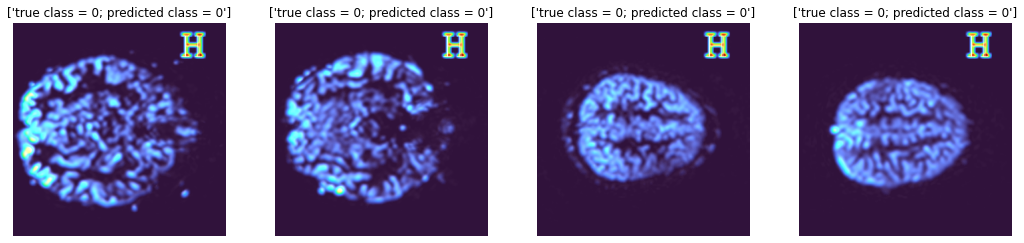

In [ ]:
#TN CNN text
img_width=320
img_height=320
fig = plt.figure(figsize=(18, 18))
cnt=0

list_GradCAM2=isel_tn_CNN_text[0:4]

for i in range(len(list_GradCAM2)):
    cnt += 1
    ax = fig.add_subplot(4, 4,cnt)
    image = x_test_text[list_GradCAM2[i]]
    X=image.reshape(1,img_width,img_height,1)
    Y=y_test_text[list_GradCAM2[i]]
    output=0
    explainer = GradCAM()
    output= explainer.explain(
        validation_data=(X, Y),
        model=CNN2,
        class_index=Y,
        layer_name=last_layer_name_cnn_text,
        colormap=cv2.COLORMAP_TURBO
    )
    ax.imshow(output)
    ax.axis('off')
    ax.set_title(['true class = {}; predicted class = {}'.format(y_test[list_GradCAM2[i]],Y)])
  
plt.show()

# Validation

In [ ]:
# ------------------------ TEST Model Verification -------------------------- #
# Scale images to the [0, 1] range
val_x = val_x.astype("float32") / 255
# Expand dimensions
val_x = np.expand_dims(val_x, -1)
print("x_train shape:", val_x.shape)
print(val_x.shape[0], "train samples")

x_train shape: (4, 320, 320, 1)
4 train samples


In [ ]:
for i in range(len(val_x)):
  image=np.expand_dims(val_x[i],0)
  y_test_prob=CNN.predict(image,verbose=0)
  y_test_pred= np.argmax(y_test_prob,axis=1)
  print("Most likely class:", y_test_pred, "-- Probability:", y_test_prob[0][y_test_pred],"-- True class:", val_y[i])

Most likely class: [0] -- Probability: [1.] -- True class: 0
Most likely class: [0] -- Probability: [1.] -- True class: 0
Most likely class: [1] -- Probability: [0.99986506] -- True class: 1
Most likely class: [1] -- Probability: [0.99937314] -- True class: 1


Above is showed the predicted class for each image, next to the predicted class probability and the true class.